# Decorators for intervals

**genominterv** provides decorators for various tasks to reduce boilerplate code.

To make it easy to create other interval functions that work across chromosomes, the module provides a genomic decorator that can be applied to functions that operate lists of `(start, end)` tuples. Applying the decorator changes the signature of a function to make it operate on DataFrames that include `chrom`, `start`, and `end` columns. 

Here is an example function that shifts the interval coordinates by 1000bp:

In [1]:
#| echo: false
import pandas as pd
import genominterv
%config InlineBackend.figure_format = 'svg'

In [2]:
intervals = pd.DataFrame(dict(chrom=['chr1', 'chr2', 'chr2'], start=[10, 20, 30], end=[15, 25, 35]))
intervals

,chrom,start,end
0,chr1,10,15
1,chr2,20,25
2,chr2,30,35


Create a function that shifts intervals three bases to the right:

In [3]:
from genominterv import genomic

@genomic
def shift_three(interv):
    return [(start+3, end+3) for (start, end) in interv]

shifted = shift_three(intervals)
shifted

,start,end,chrom
0,13,18,chr1
1,23,28,chr2
2,33,38,chr2


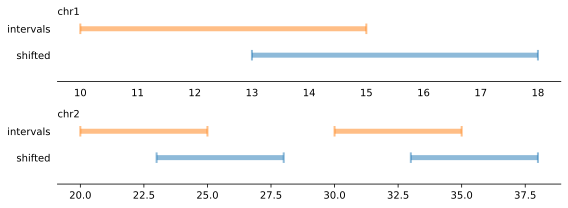

In [4]:
#| echo: false
#| label: fig-genomic
#| fig-cap: "Shifted intervals"
genominterv._plot_intervals(intervals=intervals, shifted=shifted)

## Bootstrap decorator

The bootstrap decorator turns a function producing a statistic into one that also produces a p-value. The bootstrapping resamples the intervals of the second argument for each chromosome independently. Only required argument to bootstrap is the name of the chromosome assembly used. The decorator works on any function that takes two sets of intervals. Here it is used with the [](`~genominterv.jaccard_stat`) statistic to make a `jaccard_test` function that produce a p-value for the significane of overlap between two sets.

In [5]:
annot = pd.DataFrame(dict(chrom=['chr1', 'chr2', 'chr3'], start=[30_000_000, 120_000_000, 120_000_000], 
                                        end=[60_000_000, 100_000_000, 150_000_000]))
query = pd.DataFrame(dict(chrom=['chr1', 'chr3'], start=[20_000_000, 110_000_000], 
                          end=[50_000_000, 160_000_000]))

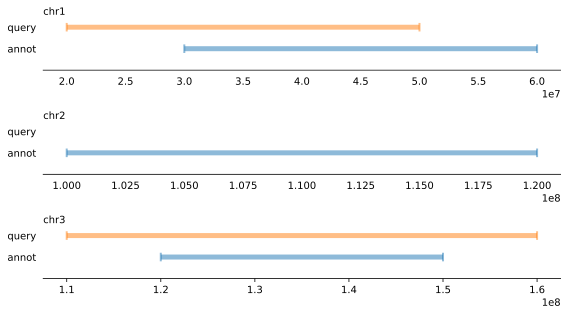

In [7]:
#| echo: false
#| label: fig-intervals
#| fig-cap: "Intervals"
genominterv._plot_intervals(annot=annot, query=query)

In [56]:
from genominterv import bootstrap, jaccard_stat

@bootstrap('hg38', samples=1000)
def jaccard_test(query, annot):
    return jaccard_stat(query, annot)

stat, p_value = jaccard_test(query, annot)
stat, p_value

(0.5555555555555556, 0.016)